In [1]:
%load_ext autoreload
%autoreload 2

%load_ext autotime

%cd ..

/Users/rubenbroekx/Documents/Projects/NumberBatchWrapper
time: 2.2 ms (started: 2021-03-14 14:08:34 +01:00)


# Performance

This notebook evaluates the performance of the model for different `level` configureations. The general rule of thumb is that a higher `level` will result in a faster performance, at the cost of more files and a slower initialisation. Note that, however, the latter should only be performed once on every machine, hence the annoyance it poses is not significant.

In [2]:
from number_batch_wrapper import Wrapper
from time import time

TIME = {}
def start(tag):
    assert tag not in TIME
    TIME[tag] = time()
    
def stop(tag, print_result:bool=True):
    assert tag in TIME
    TIME[tag] = time() - TIME[tag]
    if print_result: print_time(tag)
    
def str_time(time) -> str:
    result = ""
    if time // 3600: 
        result += f"{round(time)//3600}h "
        time %= 3600
    if time // 60: 
        result += f"{round(time)//60}m "
        time %= 60
    if time // 1:
        result += f"{round(time)//1}s "
        time %= 1
    result += f"{round(time,5):.5f}"
    return result

def print_time(tag):
    assert tag in TIME
    print(f"{tag}: {str_time(TIME[tag])}")
        
def print_time_overview():
    print(f"Time overview:")
    for k,v in sorted(TIME.items()):
        print(f" - {k}: {str_time(v)}")
        
# Load the demo-data, use to evaluate performance on
import json
from glob import glob
from pathlib import Path

with open(Path.cwd() / 'demos/data.json', 'r') as f:
    data = json.load(f)
    
# Custom cleaning and tokenization, see notebook 1_usage.ipynb
import re
from typing import List
from fold_to_ascii import fold
from stop_words import get_stop_words

def clean(x:str) -> str:
    """Custom cleaning function."""
    x = fold(x.lower())
    x = re.sub(r'[^a-z]', '', x)
    return x

STOP_EN = set(get_stop_words('en'))

def tokenize(sentence:str) -> List[str]:
    """Custom tokenizer."""
    sentence = re.split(r'\W', sentence)
    sentence = [clean(w) for w in sentence]
    sentence = [w for w in sentence if len(w) > 1 and w not in STOP_EN]
    return sentence

time: 172 ms (started: 2021-03-14 14:08:34 +01:00)


## Time

Time both the creation (`initialise`) as the inference (`__call__`) of the model. Merge these results with the memory-usage consumed and number of files that has been created. Compare against the in-memory usage of the NumberBatch embeddings, which pose a maximum in inference speeds.

### In Memory

Evaluate the performance when using the embeddings in memory. Note that for this case, the `initialisation` of `level=1` is used. This part of the notebook investigates the time it takes to embed all the data when the embeddings are pre-loaded into memory. This to form a target (maximum) inference-speed.

To load in the cleaned data into memory, 1.200 MB of memory is consumed by the notebook.

In [3]:
import numpy as np
from tqdm import tqdm
from time import sleep
from typing import Optional

time: 505 µs (started: 2021-03-14 14:08:36 +01:00)


In [4]:
# Load in data
start(f"init_in_memory")
sleep(110)  # Number of seconds it takes to clean, tokenise and store the embeddings for level 1
memory = {}
for file_path in tqdm(glob(str(Path.home() / 'numberbatch/1/_nb_en/*')), desc="Loading.."):
    with open(file_path, 'r') as f:
        for line in f.readlines():
            split = line.split()
            memory[split[0]] = np.asarray(split[1:], dtype=float)
stop(f"init_in_memory")

Loading..: 100%|██████████| 26/26 [00:18<00:00,  1.44it/s]

init_in_memory: 2m 8s 0.13399
time: 2min 8s (started: 2021-03-14 14:08:51 +01:00)


In [5]:
# Time embedding
start(f"call_in_memory")
def embed(w) -> Optional[np.ndarray]:
    if w in memory: return memory[w]
    if len(w) > 1: return embed(w[:-1])
    return None

for sentence in data:
    words = [clean(w) for w in tokenize(sentence)]
    result = np.zeros((300,))
    for word in words:
        v = embed(word)
        if v is not None: result += v
    norm = result.sum()
    result /= norm
stop(f"call_in_memory")

call_in_memory: 0.11636
time: 117 ms (started: 2021-03-14 14:11:10 +01:00)


### By Level

Evaluate the initialisation- and inference-speed of the *NumberBatchWrapper* model for all segmentation levels going from 1 to 10 (both including). 

To keep memory usage as low as possible, a word-vector is loaded in by reading it from a file. This implies that the word vector is not yet known in memory, but pre-written in *embedding files*. This will cut down memory usage significantly, but also comes at an inference cost since the files themselves need to be read in.

To increase reading speeds of the files, a *segmentation level* is implemented, that segments the vocabulary of various different files. This level depicts at which level two words are separated from each other:
 - **Level 1:** segments on the first letter, hence **a**pple and **b**ee are in different files, but **a**pple and **a**nt are not
 - **Level 2** segments on the first two letters, hence **ap**ple and **an**t wouldn't be in the same file anymore

Segmenting on the first letter drastically cuts down the average file-size, significantly decreasing reading times when looking up the corresponding word embeddings. However, this comes at the cost of an exponential increase in the number of files (possible).

The notebook, without the embeddings read in into memory, uses 95 MB of memory to operate (note, this includes the results - sentence embeddings of the data - fetched from the wrapper).

In [8]:
for level in range(1,11):
    wrapper = Wrapper(
        language='en',
        path=Path.home() / f'numberbatch/{level}',
        clean_f=clean,
        tokenizer=tokenize,
        level=level
    )
    
    start(f"init_{level}")
    wrapper.initialise(
        inp_path=Path.home() / 'Downloads'
    )
    stop(f"init_{level}")
    
    start(f"call_{level}")
    results = wrapper(data)
    stop(f"call_{level}")
    
print_time_overview()

Extracting 'en'..: 9161913it [01:09, 132336.33it/s]                             
Segmenting 'en'..: 0it [00:39, ?it/s]
Embedding: 100%|██████████| 1000/1000 [28:19<00:00,  1.70s/it] 
Extracting 'en'..: 9161913it [01:06, 137141.55it/s]                             
Segmenting 'en'..: 0it [00:39, ?it/s]
Embedding: 100%|██████████| 1000/1000 [04:36<00:00,  3.62it/s]
Extracting 'en'..: 9161913it [01:05, 139138.79it/s]                             
Segmenting 'en'..: 0it [00:41, ?it/s]
Embedding: 100%|██████████| 1000/1000 [00:45<00:00, 21.90it/s]
Extracting 'en'..: 9161913it [01:10, 130530.09it/s]                             
Segmenting 'en'..: 0it [00:52, ?it/s]
Embedding: 100%|██████████| 1000/1000 [00:14<00:00, 71.22it/s]
Extracting 'en'..: 9161913it [01:17, 118541.20it/s]                             
Segmenting 'en'..: 0it [01:04, ?it/s]
Embedding: 100%|██████████| 1000/1000 [00:08<00:00, 120.04it/s]
Extracting 'en'..: 9161913it [01:18, 116060.87it/s]                             
Segment

Time overview:
 - call_1: 28m 20s 0.50459
 - call_10: 5s 0.50755
 - call_2: 4m 36s 0.39052
 - call_3: 46s 0.70036
 - call_4: 14s 0.15349
 - call_5: 9s 0.59546
 - call_6: 6s 0.24971
 - call_7: 5s 0.79914
 - call_8: 5s 0.81513
 - call_9: 4s 0.40859
 - init_1: 1m 50s 0.92526
 - init_10: 3m 16s 0.59860
 - init_2: 1m 47s 0.30791
 - init_3: 1m 49s 0.13731
 - init_4: 2m 4s 0.74781
 - init_5: 2m 23s 0.04795
 - init_6: 2m 38s 0.51560
 - init_7: 2m 48s 0.18359
 - init_8: 3m 14s 0.70625
 - init_9: 3m 13s 0.32836
time: 59min 30s (started: 2021-03-09 20:52:01 +01:00)


In [5]:
# Count files
from glob import glob
for level in range(1,11):
    print(f"Number of files for level {level}: {len(glob(str(Path.home() / f'numberbatch/{level}/_nb_en/*')))}")

Number of files for level 1: 26
Number of files for level 2: 675
Number of files for level 3: 7914
Number of files for level 4: 37340
Number of files for level 5: 98149
Number of files for level 6: 165663
Number of files for level 7: 223269
Number of files for level 8: 268029
Number of files for level 9: 299542
Number of files for level 10: 321755
time: 8.52 s (started: 2021-03-14 12:38:11 +01:00)


## Visualise Results

TODO

In [7]:
import matplotlib.pyplot as plt

time: 2.2 s (started: 2021-03-14 14:30:26 +01:00)


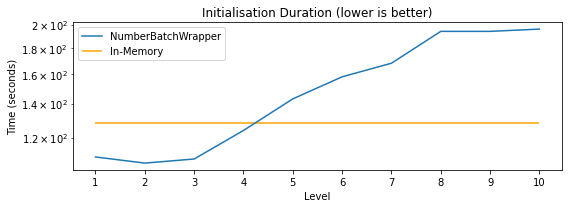

time: 754 ms (started: 2021-03-14 14:52:59 +01:00)


In [49]:
# Initialisation time in seconds
init_time = [110, 107, 109, 124, 143, 158, 168, 194, 194, 196]
init_base = 128

plt.figure(figsize=(8,3))
plt.plot(init_time, label='NumberBatchWrapper')
plt.hlines(init_base, 0,9, color='orange', label="In-Memory")
plt.title("Initialisation Duration (lower is better)")
plt.xlabel('Level')
plt.xticks(range(10), [x+1 for x in range(10)])
plt.ylabel('Time (seconds)')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig(Path.cwd() / 'img/perf_initialisation.png', dpi=300)

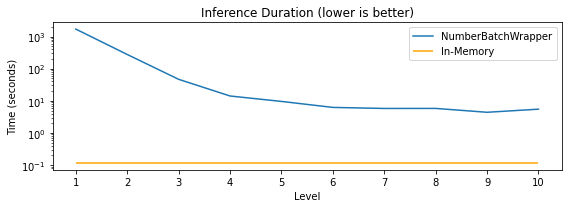

time: 941 ms (started: 2021-03-14 14:53:09 +01:00)


In [50]:
# Inference time in seconds
inf_time = [1700.504, 276.390, 46.700, 14.153, 9.595, 6.250, 5.800, 5.815, 4.409, 5.508]
inf_base = .116

plt.figure(figsize=(8,3))
plt.plot(inf_time, label='NumberBatchWrapper')
plt.hlines(inf_base, 0,9, color='orange', label="In-Memory")
plt.title("Inference Duration (lower is better)")
plt.xlabel('Level')
plt.xticks(range(10), [x+1 for x in range(10)])
plt.ylabel('Time (seconds)')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig(Path.cwd() / 'img/perf_inference.png', dpi=300)

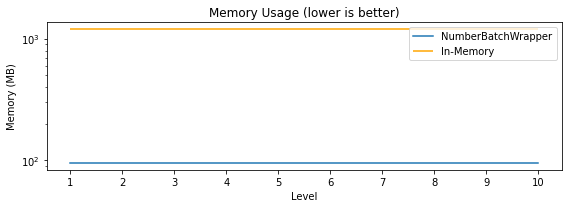

time: 707 ms (started: 2021-03-14 14:53:13 +01:00)


In [51]:
# Memory usage in megabytes
mem = [95,] * 10
mem_base = 1200

plt.figure(figsize=(8,3))
plt.plot(mem, label='NumberBatchWrapper')
plt.hlines(mem_base, 0,9, color='orange', label="In-Memory")
plt.title("Memory Usage (lower is better)")
plt.xlabel('Level')
plt.xticks(range(10), [x+1 for x in range(10)])
plt.ylabel('Memory (MB)')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig(Path.cwd() / 'img/perf_memory.png', dpi=300)

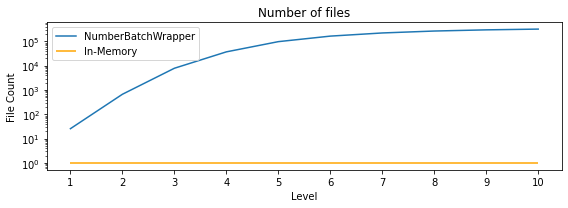

time: 1.07 s (started: 2021-03-14 14:53:15 +01:00)


In [52]:
# Number of files
files = [26, 675, 7914, 37340, 98149, 165663, 223269, 268029, 299542, 321755]
files_base = 1

plt.figure(figsize=(8,3))
plt.plot(files, label='NumberBatchWrapper')
plt.hlines(files_base, 0,9, color='orange', label="In-Memory")
plt.title("Number of files")
plt.xlabel('Level')
plt.xticks(range(10), [x+1 for x in range(10)])
plt.ylabel('File Count')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig(Path.cwd() / 'img/perf_files.png', dpi=300)

In [53]:
# Combine all images
import sys
from PIL import Image

# Get final image's dimensions
width, height = Image.open(Path.cwd() / 'img/perf_initialisation.png').size

# Merge images into a new image and save
new_im = Image.new('RGB', (2*width, 2*height))
new_im.paste(Image.open(Path.cwd() / 'img/perf_initialisation.png'), (0,0))
new_im.paste(Image.open(Path.cwd() / 'img/perf_inference.png'), (0,height))
new_im.paste(Image.open(Path.cwd() / 'img/perf_memory.png'), (width,0))
new_im.paste(Image.open(Path.cwd() / 'img/perf_files.png'), (width,height))
new_im.save(Path.cwd() / 'img/combined.png')

time: 779 ms (started: 2021-03-14 14:53:17 +01:00)
